In [1]:
import re
import os
import numpy as np
import tacco as tc
import scanpy as sc
import pandas as pd
import anndata as ad
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [2]:
work_dir = '.'

xmat_path = work_dir + '/data/Puck_200115_08.digital_expression.txt'
leiden_path = work_dir + '/store/leiden.csv'

In [3]:
xmat = pd.read_csv(xmat_path , sep="\t", index_col=0)

In [5]:
xmat = xmat.T

In [6]:
ada = ad.AnnData(X=xmat)

In [7]:
def cluster_seg_cells(adata, seg_name, result_col):
    ### adata: segmented cells to be normalised
    ### the column that contains the segmented cell clusters
    
    ### filter cells that have low avg_assignment_confidence (<0.2)
    #adata = adata[adata.obs['avg_assignment_confidence'] >= 0.2]
    
    
    
    ### QC matrices (but Xenium gene panel doesn't have mt genes...)
    adata.var_names_make_unique()
    adata.var["mt"] = adata.var_names.str.startswith("mt-")
    sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"],percent_top=(50, 100), inplace=True)
    
    
    
    ### filter cells and genes 
    sc.pp.filter_cells(adata, min_counts=50)
    sc.pp.filter_genes(adata, min_cells=5)
    
    
    
    ### normalise 
    adata.layers["counts"] = adata.X.copy()
    #sc.pp.normalize_total(adata, target_sum=1e4, inplace=True)
    sc.pp.log1p(adata)
    
    sc.tl.pca(adata, svd_solver='arpack') ### perform PCA
    sc.pp.neighbors(adata, n_neighbors=5, n_pcs=40) ### calculate neighbourhoods
    sc.tl.leiden(adata, resolution=0.3) ### clustering
    sc.tl.umap(adata) ### perform UMAP
    
    
    
    ### plot summary
    fig, ax = plt.subplots(2, 3, figsize=[18,10])
    ax[0,0] = sc.pl.violin(adata, 'n_genes_by_counts', jitter=0.4, ax=ax[0,0],show=False)
    ax[0,1] = sc.pl.violin(adata, 'total_counts', jitter=0.4, ax=ax[0,1],show=False)
    ax[0,2] = sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts',ax=ax[0,2],show=False)
    ax[1,0] = sc.pl.pca(adata, show=False, ax=ax[1,0])
    ax[1,1] = sc.pl.umap(adata, color=['leiden'], show=False, ax=ax[1,1])
    ax[1,2].axis('off')
    fig.suptitle(seg_name, fontsize=16)

    return adata, fig

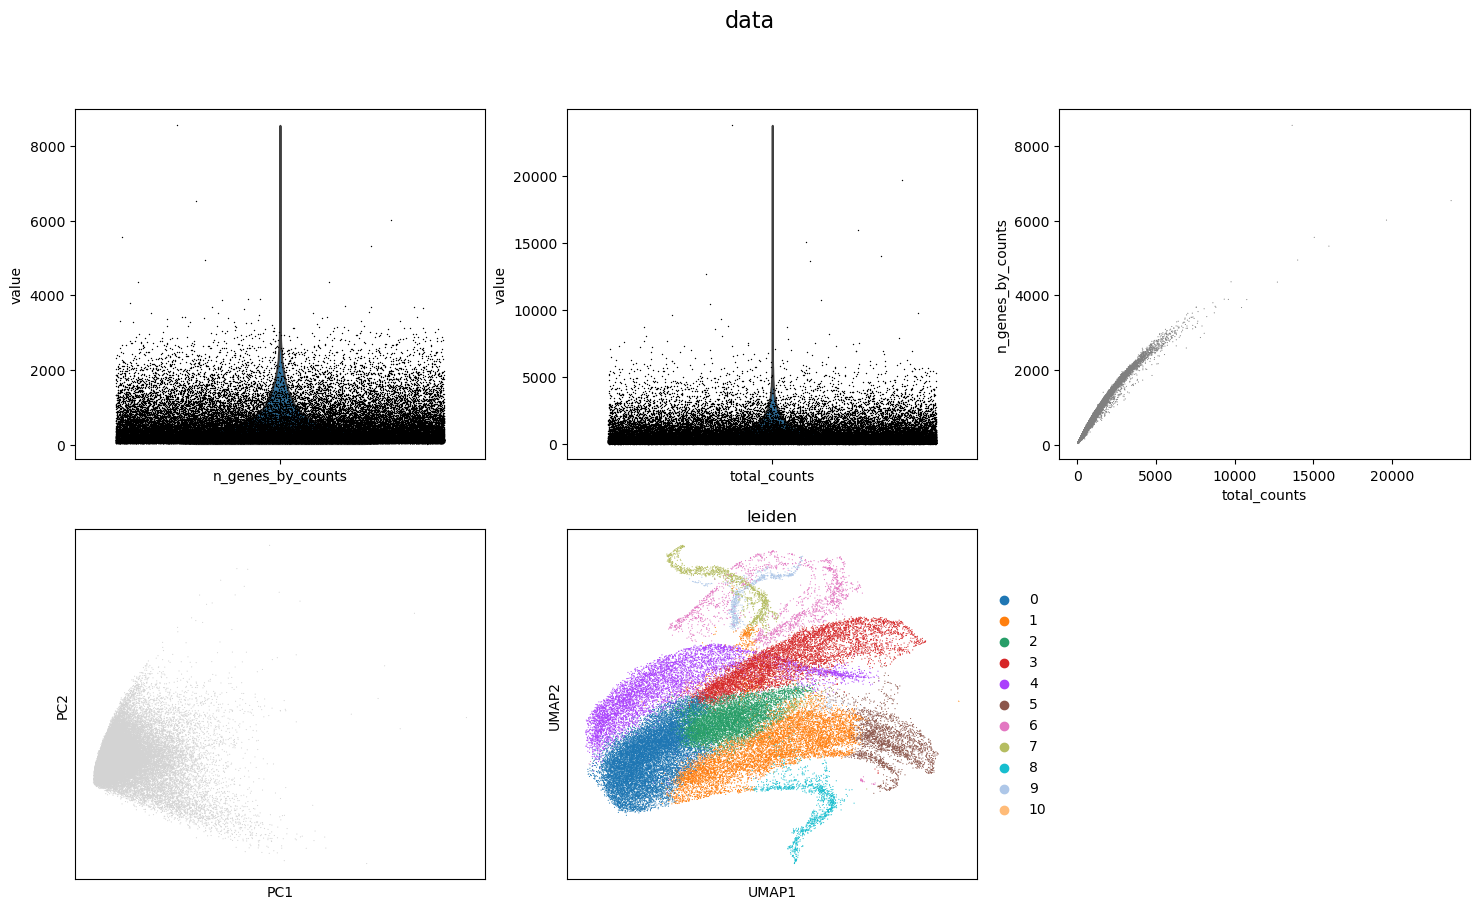

In [8]:
ada, figure1 = cluster_seg_cells(ada, 'data', 'leiden') 

In [9]:
ada.obs['leiden'].to_csv(leiden_path)